In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# **Ouverture du csv, un peu long car volumineux**

In [ ]:
df=pd.read_csv('/content/gdrive/My Drive/Val_projet/airbnb.csv',";")

Le dataframe est immense et nous n'allons pas tout utiliser, nous supprimons toutes les colonnes qui ne sont pas utiles à notre recherche. Nous pourrons toujours venir les rechercher si nous en avons le besoin


In [ ]:
#Premiere supression de variables pas utiles à notre analyse
df=df.drop(['Listing Url','Scrape ID','Last Scraped','Host Acceptance Rate','Scrape ID','Last Scraped',
            'Thumbnail Url','Medium Url','Picture Url','XL Picture Url','Host URL','Host Acceptance Rate',
           'Host Thumbnail Url','Host Picture Url','Host Verifications','Neighbourhood','Neighbourhood Group Cleansed',
           'Geolocation','Has Availability','Calendar last Scraped','License','Jurisdiction Names'], axis=1)

In [ ]:
#deuxieme supression de variables pas utiles à notre analyse
df=df.drop(['Summary','Space','Experiences Offered','Notes','Access','State','Zipcode','Host Name','Host Location','Host Neighbourhood', 'Host ID',
           'Host Listings Count','Smart Location','Country Code','Square Feet','Security Deposit','Calendar Updated',
            'Guests Included','Extra People','Street','Country','Cancellation Policy','Calculated host listings count','Features','Market'], axis=1)

In [ ]:
#On rename les colonnes qui ont des espaces
df.rename(columns={'ID':"id",'Name': 'name', 'Description': 'description', 'Host About': 'host_about', 'Host Response Time': 'host_response_time', 'Host Response Rate': 'host_response_rate', 'Host Total Listings Count': 'host_total_listing_count', 'Neighbourhood Cleansed': 'neighbourhood_cleansed' , 'City': 'city', 'Property Type': 'property_type', 'Room Type': 'room_type', 'Accommodates': 'accommodates'
, 'Bathrooms': 'bathrooms', 'Bedrooms': 'bedrooms', 'Beds': 'beds', 'Bed Type': 'bed_type', 'Amenities': 'amenities', 'Price': 'price', 'Weekly Price': 'weekly_price', 'Monthly Price': 'monthly_price', 'Cleaning Fee': 'cleaning_fee', 'Minimum Nights': 'minimum_nights', 'Maximum Nights': 'maximum_nights', 'Availability 30': 'availability_30', 'Availability 60': 'availability_60', 'Availability 90': 'availability_90', 'Availability 365': 'availability_365', 'Number of Reviews': 'number_of_reviews', 'First Review': 'first_review'
, 'Last Review': 'last_review', 'Review Scores Rating': 'review_scores_rating', 'Review Scores Accuracy': 'review_scores_accuracy', 'Review Scores Cleanliness': 'review_scores_cleanliness', 'Review Scores Checkin': 'review_scores_checkin', 'Review Scores Communication': 'review_scores_communication', 'Review Scores Location': 'review_scores_location', 'Review Scores Value': 'review_scores_value', 'Reviews per Month': 'reviews_per_month', 'Longitude': 'longitude','Latitude': 'latitude',"Neighborhood Overview":"neighborhood_overview","Transit":"transit","Interaction":"interaction","House Rules":"house_rules","Host Since":"host_since"}, inplace=True)

In [ ]:
# on met la colonne id en index

df=df.set_index("id")

In [ ]:
#Nous allons nous concentrer sur les villes de Paris et Londres, en les différenciant,
# afin de bien voir quels sont les mots les plus utilisés pour chaque ville, qui sont vraisemblablement dépendants du contexte 

df_paris=df[df.city=='Paris']
df_london=df[df.city=='London']


In [ ]:
#Nous allons garder uniquement les types de propriété 'Apartment' et 'House' qui représente 99,6% du dataset
df_paris['property_type']=df_paris['property_type'].loc[df_paris['property_type'].isin(['Apartment','House'])]
df_london['property_type']=df_london['property_type'].loc[df_london['property_type'].isin(['Apartment','House'])]


In [ ]:
#Nous allons garder uniquement les types de chambre 'Entire home/apt' et 'Private room' qui représente 99,9% du dataset
df_paris['room_type']=df_paris['room_type'].loc[df_paris['room_type'].isin(['Entire home/apt','Private room'])]
df_london['room_type']=df_london['room_type'].loc[df_london['room_type'].isin(['Entire home/apt','Private room'])]


In [ ]:

#On supprimme la première ligne de df_london car elle pose problème pour la visualisation par la suite et elle contient beaucoup de valeurs "Non-renseignées"
df_london.drop( df_london.index[0], inplace=True)


In [ ]:
#On supprime les lignes dont les reviews ne sont pas renseignés étant donnée que c'est un point important de notre analyse
df_paris=df_paris.dropna(axis=0,subset=["first_review","last_review","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","reviews_per_month"])
df_london=df_london.dropna(axis=0,subset=["first_review","last_review","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value","reviews_per_month"])

In [ ]:
#Maintenant que toutes les données ont une note attribuée, nous allons affiner en retirant les lignes qui ont des nans et qui peuvent fausser notre analyse.
df_paris=df_paris.dropna(axis=0,subset=["description","name","host_since","host_total_listing_count","price"])
df_london=df_london.dropna(axis=0,subset=["description","name","host_since","host_total_listing_count","price"]) 

In [ ]:
#df_paris["number_of_reviews"].sort_values()
#df_paris.info()
#df_paris.head()

# on considère les annonces qui ont le plus de reviews comme celles qui ont 300 reviews ou plus
# et celles qui ont le moins de reviews sont les annonces ayant moins de 10 reviews


df_paris_nombreuses_reviews=df_paris[df_paris.number_of_reviews>=300]
df_paris_nombreuses_reviews.head()

,name,description,neighborhood_overview,transit,interaction,house_rules,host_since,host_about,host_response_time,host_response_rate,host_total_listing_count,neighbourhood_cleansed,city,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,cleaning_fee,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
629248,Charming room in spacious apartment,"Charming room (16m2), in a bright and quiet ap...",The apartment is extremely well located in the...,"Great transport service, with two metro lines ...",About ten days before your arrival I send you ...,"Polite, discreet and respectful",2012-08-01,I am a fifty-eight year old woman whose daught...,within an hour,100.0,2.0,Popincourt,Paris,48.851391,2.385443,Apartment,Private room,2.0,2.0,1.0,1.0,Real Bed,"Wireless Internet,Kitchen,Smoking allowed,Door...",60.0,NaN,NaN,NaN,1.0,7.0,1.0,4.0,10.0,243.0,488.0,2012-08-27,2017-03-31,93.0,9.0,10.0,10.0,9.0,9.0,9.0,8.69
35065,Lovely Loft Saint-Germain des Pres,A very nice apartment that was completely reno...,NaN,NaN,Communication is always very smooth : - Phone ...,Housekeeping : A housekeeper comes after every...,2010-06-23,(SENSITIVE CONTENTS HIDDEN) Likes:\r\nAu Revoi...,within a few hours,96.0,1.0,Palais-Bourbon,Paris,48.853866,2.324397,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Wheelch...",141.0,NaN,NaN,NaN,1.0,10.0,2.0,4.0,13.0,262.0,332.0,2010-09-08,2017-03-19,91.0,9.0,9.0,9.0,9.0,10.0,9.0,4.15
2412144,studio st lazare opéra madeleine,"studio (15m2), comfortable, at the 6th floor w...","everything in the street for food market, phar...",from roissy airport direct bus at the corner o...,i ll be there for check in and check out very ...,"it s a quiet building, hope you will be respec...",2013-06-15,"sportif, open mind, use to travel and try to o...",within an hour,100.0,2.0,Opéra,Paris,48.872563,2.328991,Apartment,Entire home/apt,2.0,2.5,0.0,1.0,Pull-out Sofa,"Wireless Internet,Kitchen,Elevator in building...",45.0,401.0,1603.0,NaN,1.0,30.0,0.0,7.0,9.0,62.0,342.0,2014-02-24,2017-04-01,95.0,10.0,10.0,10.0,10.0,10.0,10.0,9.02
1199566,Nice studio close to Eiffel tower,22 m2 flat on the first floor (2d floor with U...,NaN,NaN,NaN,No music after 11 pm Check out before 11 am C...,2012-05-23,I enjoy traveling and it's a great pleasure f...,within an hour,100.0,2.0,Palais-Bourbon,Paris,48.857715,2.306884,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",95.0,NaN,NaN,NaN,1.0,35.0,0.0,0.0,9.0,115.0,388.0,2013-06-05,2017-03-31,94.0,10.0,9.0,10.0,10.0,10.0,9.0,8.31
36689,Studio Paris 13,In the 13th district ( arrondissement ) in th...,NaN,Metro station Tolbiac (line 7) at 650(URL HIDD...,NaN,No smoking Clean the place before leaving,2010-03-15,I am a 50 years old guy who is very friendly ...,within a few hours,95.0,3.0,Gobelins,Paris,48.826247,2.350529,Apartment,Entire home/apt,3.0,1.0,NaN,1.0,Pull-out Sofa,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",47.0,NaN,NaN,NaN,1.0,1125.0,16.0,32.0,62.0,334.0,322.0,2010-08-03,2017-03-25,87.0,9.0,8.0,10.0,9.0,9.0,9.0,3.96


In [ ]:
# Importations

## for data
import collections
import json
## for plotting
import wordcloud
## for text processing
import re
import nltk
## for language detection
!pip install langdetect
import langdetect 
## for sentiment
from textblob import TextBlob
## for ner
import spacy
## for vectorizer
from sklearn import feature_extraction, manifold
## for word embedding
import gensim.downloader as gensim_api
## for topic modeling
import gensim

     |████████████████████████████████| 981 kB 5.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=71ded5e0efed1f50e96484cf9b2d40c9f06b09294f1decef0970c75a99ba074b
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
# On analyse les mots utilisés dans les descriptions des annonces ayant le plus de reviews et dans celles en ayant le moins
description_string = "\n\n".join(df_paris_nombreuses_reviews.description)

In [ ]:
#Commençons par nettoyer les données textuelles de la variable description

description_string = re.sub('\s+',' ',description_string).strip().lower()
description_string[:600]

'charming room (16m2), in a bright and quiet apartment, safe and secure exceptionally located near the bastille district, le marais and nation. breakfast included with fresh french bread . lively neighbourhoods. supermarket, grocery stores, bakeries. breakfast included. the apartment features three bedrooms: mine and two that are available for airbnb guests, a big kitchen with dining room and a separate toilet. i have my own bathroom with toilet. there is a second bathroom with shower for airbnb guests only. if needed for long stays, a washing machine is also available. hours check-in and check'

In [ ]:
r=re.compile(r"[0-9]")
description_string=r.sub(" ",description_string)
description_string[:600]

'charming room (  m ), in a bright and quiet apartment, safe and secure exceptionally located near the bastille district, le marais and nation. breakfast included with fresh french bread . lively neighbourhoods. supermarket, grocery stores, bakeries. breakfast included. the apartment features three bedrooms: mine and two that are available for airbnb guests, a big kitchen with dining room and a separate toilet. i have my own bathroom with toilet. there is a second bathroom with shower for airbnb guests only. if needed for long stays, a washing machine is also available. hours check-in and check'

In [ ]:
r=re.compile(r"[\-\.\:\)\(\,\+\*\#\!\?\@\°\<\>\&\;\'\"\[\]]")
description_string=r.sub(" ",description_string)
description_string[:600]

'charming room    m    in a bright and quiet apartment  safe and secure exceptionally located near the bastille district  le marais and nation  breakfast included with fresh french bread   lively neighbourhoods  supermarket  grocery stores  bakeries  breakfast included  the apartment features three bedrooms  mine and two that are available for airbnb guests  a big kitchen with dining room and a separate toilet  i have my own bathroom with toilet  there is a second bathroom with shower for airbnb guests only  if needed for long stays  a washing machine is also available  hours check in and check'

In [ ]:
r=re.compile(r"[\s]{2,}")
description_string=r.sub(" ",description_string)
description_string[:600]

'charming room m in a bright and quiet apartment safe and secure exceptionally located near the bastille district le marais and nation breakfast included with fresh french bread lively neighbourhoods supermarket grocery stores bakeries breakfast included the apartment features three bedrooms mine and two that are available for airbnb guests a big kitchen with dining room and a separate toilet i have my own bathroom with toilet there is a second bathroom with shower for airbnb guests only if needed for long stays a washing machine is also available hours check in and check out are totally flexib'

In [ ]:
r=re.compile(r"\bdb\b")
description_string=r.sub("double",description_string)
description_string[:600]

'charming room m in a bright and quiet apartment safe and secure exceptionally located near the bastille district le marais and nation breakfast included with fresh french bread lively neighbourhoods supermarket grocery stores bakeries breakfast included the apartment features three bedrooms mine and two that are available for airbnb guests a big kitchen with dining room and a separate toilet i have my own bathroom with toilet there is a second bathroom with shower for airbnb guests only if needed for long stays a washing machine is also available hours check in and check out are totally flexib'

In [ ]:
r=re.compile(r"\binc\b")
description_string=r.sub("included",description_string)
description_string[:600]

'charming room m in a bright and quiet apartment safe and secure exceptionally located near the bastille district le marais and nation breakfast included with fresh french bread lively neighbourhoods supermarket grocery stores bakeries breakfast included the apartment features three bedrooms mine and two that are available for airbnb guests a big kitchen with dining room and a separate toilet i have my own bathroom with toilet there is a second bathroom with shower for airbnb guests only if needed for long stays a washing machine is also available hours check in and check out are totally flexib'

In [ ]:
r=re.compile(r"\bwi\sfi\b")
description_string=r.sub("wifi",description_string)
description_string[:900]

'charming room m in a bright and quiet apartment safe and secure exceptionally located near the bastille district le marais and nation breakfast included with fresh french bread lively neighbourhoods supermarket grocery stores bakeries breakfast included the apartment features three bedrooms mine and two that are available for airbnb guests a big kitchen with dining room and a separate toilet i have my own bathroom with toilet there is a second bathroom with shower for airbnb guests only if needed for long stays a washing machine is also available hours check in and check out are totally flexible you have a key that allows you to enter and exit whenever you want respecting of course the calm of the apartment i ll give you all tips you need about ten days before your arrival i send you my complete address and phone number when you communicate me your arrival time and according to your plac'

In [ ]:
r=re.compile(r"\bnr\b")
description_string=r.sub("near",description_string)
#name_string[:900]

In [ ]:
import re
def remove_emojis(description_string):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',description_string)

In [ ]:
# tokenisation
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tokenizer=PunktSentenceTokenizer()
tokenizer.tokenize(description_string)
description_tokenized=word_tokenize(description_string,language="english")
#description_tokenized[:90]

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words.update(["br","two","k","bd","and","br","la","m","le","dans","de","g","les","des","du","one","st","et","à","un","est","l","avec","une","pour","en","au"])
# j'ajoute manuellement les stop words en français les plus communs 
# nous avons choisi de garder les 2 langues car beaucoup de propriétaires français écrivent en anglais pour les touristes internationaux
# Comme nous comprenons les deux langues cela n'est pas vraiment gênant pour notre analyse, à l'interne

In [ ]:
def stop_words_filtering(description_tokenized) : 
    tokens = []
    for mot in description_tokenized:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

In [ ]:
filtered_description = [w for w in description_tokenized if not w.lower() in stop_words]
 
filtered_description = []
 
for w in description_tokenized:
    if w not in stop_words:
        filtered_description.append(w)
 
#print(description_tokenized)
#filtered_description[:90]

In [ ]:
# Vectorisation:

# Connaître l'occurence des mots utilisés pour décrire les logements:

from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer()
vectorizer.fit_transform(filtered_description)
tokenized=vectorizer.vocabulary_
#tokenized


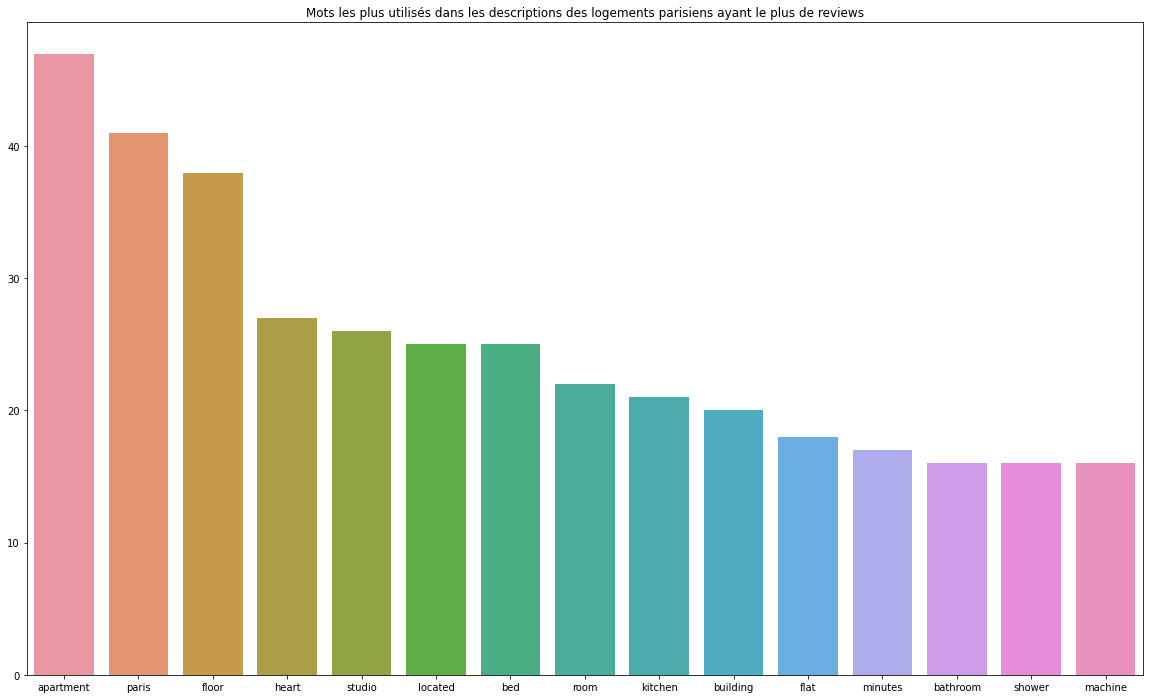

In [ ]:
from collections import Counter
import seaborn as sns
dico=Counter(filtered_description)
mots=[m[0] for m in dico.most_common(15)]
freq=[m[1] for m in dico.most_common(15)]
plt.figure(figsize=(20,12))
sns.barplot(x=mots,y=freq)
plt.title("Mots les plus utilisés dans les descriptions des logements parisiens ayant le plus de reviews");


In [ ]:
#Faisons la même chose avec les logements ayant le plus de reviews à Londres 

df_london["number_of_reviews"].sort_values()


# on considère les annonces qui ont le plus de reviews comme celles qui ont 300 reviews ou plus
# et celles qui ont le moins de reviews sont les annonces ayant moins de 10 reviews


df_london_nombreuses_reviews=df_london[df_london.number_of_reviews>=300]


In [ ]:
description_string_london = "\n\n".join(df_london_nombreuses_reviews.description)

In [ ]:
#nettoyage des données textuelles
description_string_london = re.sub('\s+',' ',description_string_london).strip().lower()
description_string_london[:600]

"an affordable place to stay right in the heart of london. don't waste time and money on public transport, be in the middle of all happenings. perfect for adventurous travellers! feel free to have a look at the pictures provided and read the captions to get an idea of what's around. for food and drinks + points of interests, check-out my airbnb guidebook. i'd always advise guests to read the whole description and some reviews to make sure the place is suitable. :-) having holidays in central london for money far below the hotel prices is now possible. i have a nice studio flat to offer located "

In [ ]:
r=re.compile(r"[0-9]")
description_string_london=r.sub(" ",description_string_london)

r=re.compile(r"[\-\.\:\)\(\,\+\*\#\!\?\@\°\<\>\&\;\'\"\[\]]")
description_string_london=r.sub(" ",description_string_london)

r=re.compile(r"[\s]{2,}")
description_string_london=r.sub(" ",description_string_london)

r=re.compile(r"\bdb\b")
description_string_london=r.sub("double",description_string_london)

r=re.compile(r"\bwi\sfi\b")
description_string_london=r.sub("wifi",description_string_london)

r=re.compile(r"\bnr\b")
description_string_london=r.sub("near",description_string_london)

description_string_london[:600]

'an affordable place to stay right in the heart of london don t waste time and money on public transport be in the middle of all happenings perfect for adventurous travellers feel free to have a look at the pictures provided and read the captions to get an idea of what s around for food and drinks points of interests check out my airbnb guidebook i d always advise guests to read the whole description and some reviews to make sure the place is suitable having holidays in central london for money far below the hotel prices is now possible i have a nice studio flat to offer located right in the ce'

In [ ]:
import re
def remove_emojis(description_string_london):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',description_string_london)

In [ ]:
tokenizer=PunktSentenceTokenizer()
tokenizer.tokenize(description_string_london)
description_string_london_tokenized=word_tokenize(description_string_london,language="english")


In [ ]:
stop_words=set(stopwords.words("english"))
stop_words.update(["br","two","k","bd","and","br","m","one","st","l","s","also"])

def stop_words_filtering(description_string_london_tokenized) : 
    tokens = []
    for mot in description_string_london_tokenized:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

filtered_description_london = [w for w in description_string_london_tokenized if not w.lower() in stop_words]
filtered_description_london = []
 
for w in description_string_london_tokenized:
    if w not in stop_words:
        filtered_description_london.append(w)

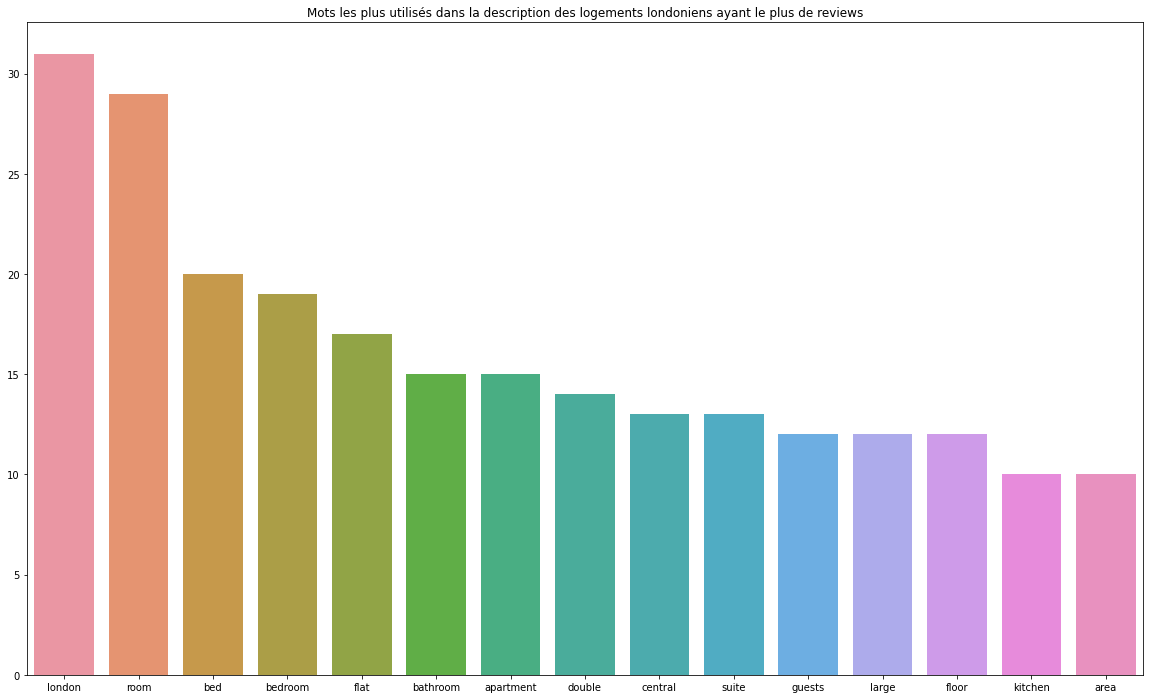

In [ ]:
vectorizer=CountVectorizer()
vectorizer.fit_transform(filtered_description_london)
tokenized=vectorizer.vocabulary_

dico=Counter(filtered_description_london)
mots=[m[0] for m in dico.most_common(15)]
freq=[m[1] for m in dico.most_common(15)]
plt.figure(figsize=(20,12))
sns.barplot(x=mots,y=freq)
plt.title("Mots les plus utilisés dans la description des logements londoniens ayant le plus de reviews");

In [ ]:
# Regardons maintenant les descriptions des logements ayant le moins de reviews dans ces deux villes

# on ne garde que les annonces qui ont 10 annonces ou moins

df_paris_peu_reviews=df_paris[df_paris.number_of_reviews <= 10]



In [ ]:

description_peu_reviews_string = "\n\n".join(df_paris_peu_reviews.description)

In [ ]:

description_peu_reviews_string = re.sub('\s+',' ',description_peu_reviews_string).strip().lower()
r=re.compile(r"[0-9]")
description_peu_reviews_string=r.sub(" ",description_peu_reviews_string)
r=re.compile(r"[\-\.\:\)\(\,\+\*\#\!\?\@\°\<\>\&\;\'\"\[\]]")
description_peu_reviews_string=r.sub(" ",description_peu_reviews_string)
r=re.compile(r"[\s]{2,}")
description_peu_reviews_string=r.sub(" ",description_peu_reviews_string)
r=re.compile(r"\bdb\b")
description_peu_reviews_string=r.sub("double",description_peu_reviews_string)
r=re.compile(r"\binc\b")
description_peu_reviews_string=r.sub("included",description_peu_reviews_string)
r=re.compile(r"\bwi\sfi\b")
description_peu_reviews_string=r.sub("wifi",description_peu_reviews_string)
r=re.compile(r"\bnr\b")
description_peu_reviews_string=r.sub("near",description_peu_reviews_string)

In [ ]:
import re
def remove_emojis(description_peu_reviews_string):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',description_mauvais_string)

In [ ]:
tokenizer=PunktSentenceTokenizer()
tokenizer.tokenize(description_peu_reviews_string)
description_peu_reviews_tokenized=word_tokenize(description_peu_reviews_string,language="english")

In [ ]:
stop_words=set(stopwords.words("english"))
stop_words.update(["br","two","k","bd","and","br","la","m","le","dans","de","g","les","des","du","one","st","et","à","un","est","l","avec","une","pour","en","au"])
# on ajoute des stop words français 

In [ ]:
def stop_words_filtering(description_peu_reviews_tokenized) : 
    tokens = []
    for mot in description_peu_reviews_tokenized:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

In [ ]:
filtered_description_peu_reviews= [w for w in description_peu_reviews_tokenized if not w.lower() in stop_words]
 
filtered_description_peu_reviews = []
 
for w in description_peu_reviews_tokenized:
    if w not in stop_words:
        filtered_description_peu_reviews.append(w)

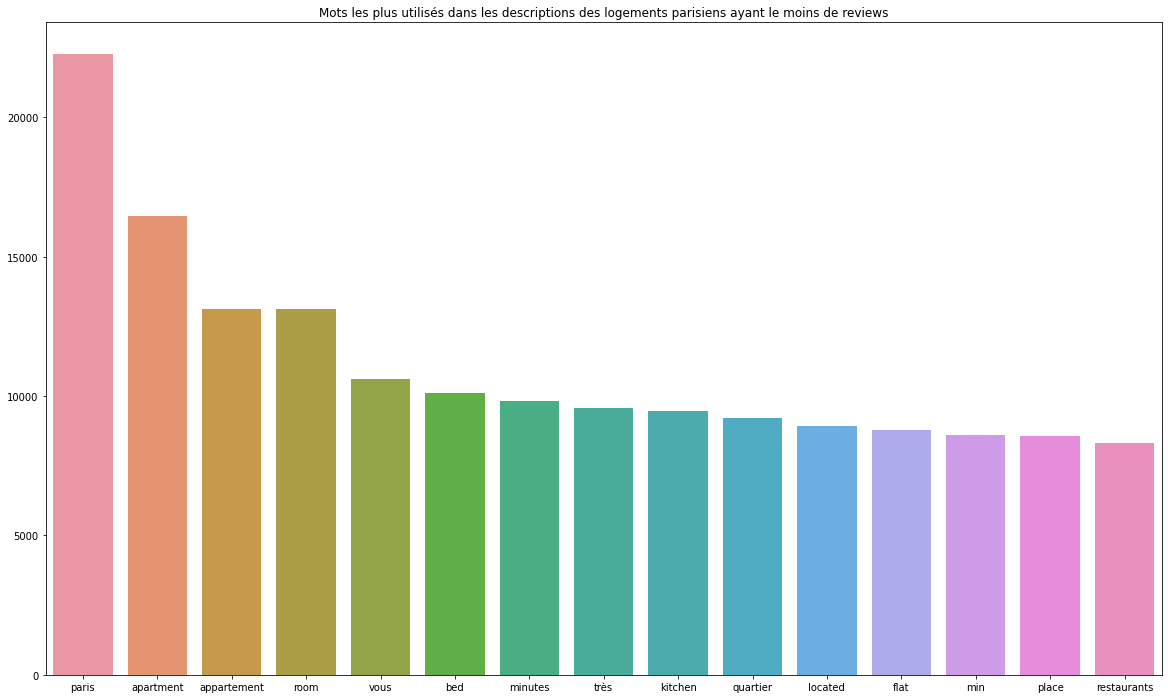

In [ ]:
dico=Counter(filtered_description_peu_reviews)
mots=[m[0] for m in dico.most_common(15)]
freq=[m[1] for m in dico.most_common(15)]
plt.figure(figsize=(20,12))
sns.barplot(x=mots,y=freq)
plt.title("Mots les plus utilisés dans les descriptions des logements parisiens ayant le moins de reviews");


In [ ]:
# on remarque que les mots les plus fréquents sont très similaires. Aucune différence notable ne ressort.

In [ ]:

df_london_peu_reviews=df_london[df_london.number_of_reviews <= 10]

In [ ]:
description_string_peu_london = "\n\n".join(df_london_peu_reviews.description)
description_string_peu_london = re.sub('\s+',' ',description_string_peu_london).strip().lower()
r=re.compile(r"[0-9]")
description_string_peu_london=r.sub(" ",description_string_peu_london)
r=re.compile(r"[\-\.\:\)\(\,\+\*\#\!\?\@\°\<\>\&\;\'\"\[\]]")
description_peu_mauvais_london=r.sub(" ",description_string_peu_london)
r=re.compile(r"[\s]{2,}")
description_string_peu_london=r.sub(" ",description_string_peu_london)
r=re.compile(r"\bdb\b")
description_string_peu_london=r.sub("double",description_string_peu_london)
r=re.compile(r"\binc\b")
description_string_peu_london=r.sub("included",description_string_peu_london)
r=re.compile(r"\bwi\sfi\b")
description_string_peu_london=r.sub("wifi",description_string_peu_london)
r=re.compile(r"\bnr\b")
description_string_peu_london=r.sub("near",description_string_peu_london)

In [ ]:
import re
def remove_emojis(description_string_peu_london):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',description_string_peu_london)

In [ ]:
tokenizer=PunktSentenceTokenizer()
tokenizer.tokenize(description_string_peu_london)
description_tokenized_peu_london=word_tokenize(description_string_peu_london,language="english")

In [ ]:
stop_words=set(stopwords.words("english"))
stop_words.update(["br","two","k","bd","and","br","one","st",",",".","(",")","'s","!","-"])

def stop_words_filtering(description_tokenized_peu_london) : 
    tokens = []
    for mot in description_tokenized_peu_london:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

In [ ]:
filtered_description_peu_london = [w for w in description_tokenized_peu_london if not w.lower() in stop_words]
 
filtered_description_peu_london = []
 
for w in description_tokenized_peu_london:
    if w not in stop_words:
        filtered_description_peu_london.append(w)

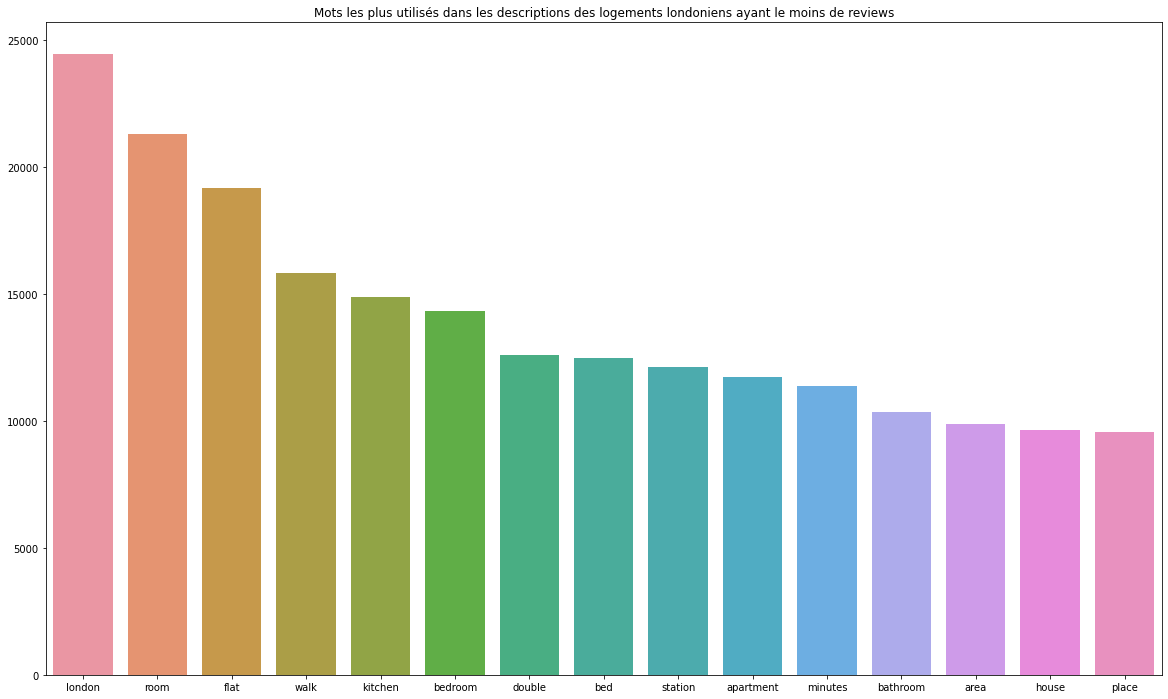

In [ ]:
dico=Counter(filtered_description_peu_london)
mots=[m[0] for m in dico.most_common(15)]
freq=[m[1] for m in dico.most_common(15)]
plt.figure(figsize=(20,12))
sns.barplot(x=mots,y=freq)
plt.title("Mots les plus utilisés dans les descriptions des logements londoniens ayant le moins de reviews");

In [ ]:
# on ne remarque pas de différence notable entre les logements ayant le plus de review et ceux en ayant le moins

In [ ]:
b